\# **Notebook for reproducing Delauney Rewiring results**

In [1]:
# Install required packages.
import os
import torch

os.environ["TORCH"] = torch.__version__
print(torch.__version__)

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    reducer = umap.UMAP(n_components=2)
    z = reducer.fit_transform(data.x)

    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

2.2.2


In [2]:
!pip install -U umap-learn ml_dtypes

In [3]:
import umap

An example from the Roman-Empire dataset

In [4]:
from torch_geometric.datasets import (
    Planetoid,
    Amazon,
    WebKB,
    HeterophilousGraphDataset,
    WikipediaNetwork,
    CitationFull,
    Actor,
)
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import (
    homophily,
    add_self_loops,
    is_undirected,
    to_networkx,
    from_networkx,
    to_undirected,
    to_dense_adj,
    dense_to_sparse,
    contains_self_loops,
)
import time

In [5]:
# dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
# dataset = Amazon(root='data/amazon', name='photo', transform=NormalizeFeatures())
dataset = WebKB(root="data/", name="Wisconsin", transform=NormalizeFeatures())
# dataset = CitationFull(root='data/Citeseer', name='Citeseer', to_undirected = False)#
# dataset = WikipediaNetwork(root='data/WikipediaNetwork', name='squirrel')#, transform=NormalizeFeatures())
# dataset = HeterophilousGraphDataset(root='data/Roman-Empire', name='Roman-Empire')#,transform=NormalizeFeatures())
# dataset = Actor(root='data/Actor')
# dataset = Twitch(root='data/twitch',name='DE')
# dataset = DeezerEurope(root='data/DeezerEurope')
# dataset = Flickr(root='data/Flickr')
# dataset =  LINKXDataset(root='data/LINKXDataset',name='genius')

print()
print(f"Dataset: {dataset}:")
print("======================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data = dataset[0]  # Get the first graph object.

print()
print(data)
print(
    "==========================================================================================================="
)

# Gather some statistics about the graph.
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")


print(f"Number of training nodes: {data.train_mask.sum()}")
print(
    f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}"
)
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

data_und = to_undirected(data.edge_index)
# data_und,_= add_self_loops(data_und, num_nodes=data.num_nodes)


Dataset: wisconsin():
Number of graphs: 1
Number of features: 1703
Number of classes: 5

Data(x=[251, 1703], edge_index=[2, 515], y=[251], train_mask=[251, 10], val_mask=[251, 10], test_mask=[251, 10])
Number of nodes: 251
Number of edges: 515
Average node degree: 2.05
Number of training nodes: 1200
Training node label rate: 4.78
Has isolated nodes: False
Has self-loops: True
Is undirected: False


Processing...
Done!


Dimension reduction with UMAP

In [6]:
reducer = umap.UMAP(n_components=2)
reduced_data = reducer.fit_transform(data.x)
type(reduced_data)

/Users/tristanwaddington/anaconda3/envs/Delauney/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


numpy.ndarray

Build the graph

In [7]:
import torch
import torch_geometric
import networkx as nx
from scipy.spatial import Delaunay
import time


def create_delaunay_graph(positions):
    positions = positions.cpu().numpy()
    start_time = time.time()
    delaunay = Delaunay(positions, qhull_options="QJ")

    edges = []
    for simplex in delaunay.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                edge = (simplex[i], simplex[j])
                edgess = (simplex[j], simplex[i])
                edges.append(edge)
                edges.append(edgess)

    delaunay_graph = nx.Graph(edges)

    edge_index = torch.tensor(list(delaunay_graph.edges)).t().contiguous()
    data = torch_geometric.data.Data(edge_index=edge_index)
    print(time.time() - start_time)
    return data


new_data = create_delaunay_graph(torch.tensor(reduced_data))
delauney_G = to_undirected(new_data.edge_index)

0.0055768489837646484


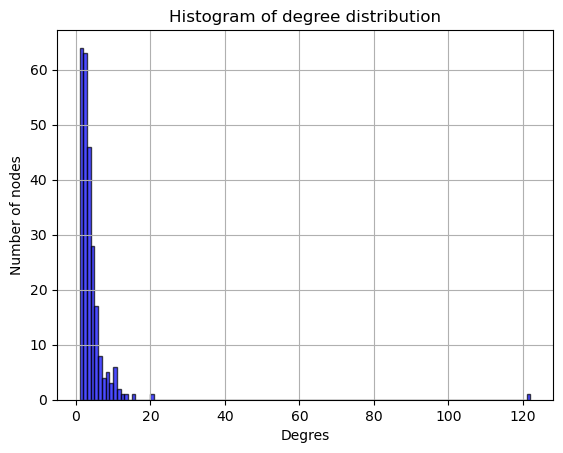

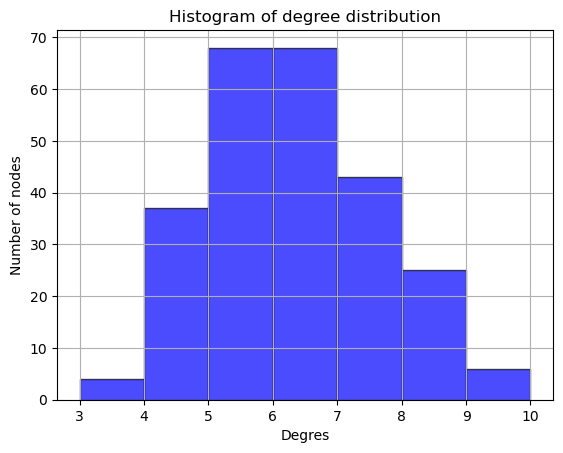

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


def repart_D(edge):
    edge_list = edge.T.numpy().tolist()

    G = nx.Graph(edge_list)

    degrees = [val for (node, val) in G.degree()]

    plt.hist(
        degrees,
        bins=range(min(degrees), max(degrees) + 1),
        alpha=0.7,
        color="b",
        edgecolor="black",
    )
    plt.xlabel("Degres")
    plt.ylabel("Number of nodes")
    plt.title("Histogram of degree distribution")
    plt.grid(True)
    plt.show()
    return degrees


degrees_O = repart_D(data_und)
degrees_Delau = repart_D(delauney_G)

In [9]:
import numpy as np


def D_info(edge):
    G = nx.Graph()
    G.add_edges_from(edge.t().tolist())

    degrees = dict(G.degree())

    max_degree = np.max(list(degrees.values()))
    min_degree = np.min(list(degrees.values()))
    avg_degree = np.mean(list(degrees.values()))

    print("Max degree:", max_degree)
    print("Min :", min_degree)
    print("Mean degree :", avg_degree)


print("original Graph")
D_info(data_und)
print("----------------")
print("Delauney Graph")
D_info(delauney_G)

original Graph
Max degree: 122
Min : 1
Mean degree : 3.7131474103585655
----------------
Delauney Graph
Max degree: 10
Min : 3
Mean degree : 5.8326693227091635


Import the libraries needed to calculate the curvature

In [10]:
!pip install GraphRicciCurvature
from GraphRicciCurvature.OllivierRicci import OllivierRicci
import networkx as nx

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


import networkx as nx
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

# to print logs in jupyter notebook
import logging

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)

# load GraphRicciCuravture package
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 4.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 4.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9388 sha256=55920d61f370bf19b0eafb2a4612c719fb0b1792428906fdd2e003854d46f3a6
  Stored in directory: /Users/tristanwaddington/Library/Caches/pip/wheels/11/c1/e7/f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain


Calculate curvature according to Ollivier

In [ ]:
def show_results(edge):
    G = nx.Graph()
    G.add_edges_from(edge.t().tolist())
    orc = OllivierRicci(G, alpha=0.5, verbose="TRACE")
    orc.compute_ricci_curvature()
    G = orc.G.copy()
    # Plot the histogram of Ricci curvatures
    plt.subplot(2, 1, 1)
    ricci_curvtures = nx.get_edge_attributes(G, "ricciCurvature").values()

    values = list(ricci_curvtures)
    values.sort()

    n = len(values)

    squash_index = int(n * 0.1)
    q1 = values[squash_index]

    values = list(ricci_curvtures)
    values.sort(reverse=True)
    n = len(values)

    smooth_index = int(n * 0.1)
    q10 = values[smooth_index]

    bins = np.arange(-0.75, 1, 0.25)
    print("Premier déciles (Q1) :", q1)
    print("Derniere déciles :", q10)
    n, bins, patches = plt.hist(ricci_curvtures)
    plt.xlabel("Ricci curvature")
    plt.ylabel("Number of edges")

    plt.title("Histogram of Ricci Curvatures " + str(dataset))


print("original Graph")
show_results(data_und)
print("----------------")
print("Delauney Graph")
show_results(delauney_G)

INFO:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:Self-loop edge detected. Removing 16 self-loop edges.
TRACE:Number of nodes: 251
TRACE:Number of edges: 450
TRACE:Start to compute all pair shortest path.


original Graph


Measurement of homophily on edges presented by Zhu et al.

In [ ]:
print("Homophily of original graph")
print(homophily(data_und, data.y))
print("----------------------")
print("Homophily of Delauney graph")
print(homophily(delauney_G, data.y))

Homophily of original graph
0.19213974475860596
----------------------
Homophily of Delauney graph
0.6950724720954895


Add Self loops for experiments

In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.conv1(x.to(device), delauney_G.to(device))
        x = x.relu()
        x = F.dropout(x.to(device), p=0.5, training=self.training)
        x = self.conv2(x.to(device), delauney_G.to(device))
        return x.to(device)

In [ ]:
from torch_geometric.nn import GATConv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(
            dataset.num_features, hidden_channels, heads=8, dropout=0.5
        )
        self.conv2 = GATConv(
            hidden_channels * 8, dataset.num_classes, heads=1, dropout=0.5
        )

    def forward(self, x):
        x = F.elu(self.conv1(x.to(device), delauney_G.to(device)))
        x = F.dropout(x.to(device), p=0.5, training=self.training)
        x = self.conv2(x.to(device), delauney_G.to(device))
        return x.to(device)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()


def train(t, v):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device))
    loss = criterion(out[data_train_mask], data.y.to(device)[data_train_mask])
    val_loss = criterion(out[v].to(device), data.y.to(device)[v])
    loss.backward()
    optimizer.step()
    return loss, val_loss


def test(mask):
    model.eval()
    out = model(data.x.to(device))
    pred = out.argmax(dim=1)
    correct = pred[mask] == data.y.to(device)[mask]
    acc = int(correct.sum()) / int(mask.sum())
    return acc

In [ ]:
delauney_G, _ = add_self_loops(delauney_G, num_nodes=data.num_nodes)

An exemple of experiments on 10runs. On the paper we report the average accuracy  across 100 random samples. The hyperparameters is the same that Pei et al. (Geom-GCN: Geometric Graph Convolutional Networks).

In [ ]:
import time
import numpy as np

ramdom = True
moy = []
ep = []
T = []
p_m = []
nb_runs = 10
hidden_channels = 32
lr = 0.005
weight_decay = 5e-6
moy = []
ep = []
for runs in range(nb_runs):
    model = GCN(hidden_channels=hidden_channels).to(device)
    # model = GAT(hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay
    )

    criterion = torch.nn.CrossEntropyLoss()
    print("runs", runs)
    start_time = time.time()
    shuffled_indices = torch.randperm(len(data.y))

    indices = [False for i in range(len(data.y))]
    mask_train = [
        True if i in shuffled_indices[: int(0.6 * len(data.y))] else False
        for i in range(len(indices))
    ]
    mask_val = [
        True
        if i
        in shuffled_indices[int(0.6 * len(data.y)) : int(0.8 * len(data.y))]
        else False
        for i in range(len(indices))
    ]
    mask_test = [
        True
        if i in shuffled_indices[int(0.8 * len(data.y)) : len(data.y)]
        else False
        for i in range(len(indices))
    ]

    data_train_mask = torch.tensor(mask_train)
    data_val_mask = torch.tensor(mask_val)
    data_test_mask = torch.tensor(mask_test)
    best_val_acc = 0
    i = 0
    for epoch in range(1, 2001):
        loss, val_loss = train(data_train_mask, data_val_mask)
        val_acc = test(data_val_mask)
        train_acc = test(data_train_mask)
        test_acc = test(data_test_mask)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            Test_acc = test_acc
            i = 0
        i = i + 1
        # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f},Train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f},test_acc: {test_acc:.4f}')
        # print(i)
        if i == 100:
            break

    T.append(time.time() - start_time)
    print(f"Test Accuracy: {Test_acc:.4f}")
    moy.append(Test_acc)
    ep.append(epoch)
print("-------------------------")
print("mod", model)
print("hidden_channels", hidden_channels)
print("weight_decay", weight_decay)
print("lr", lr)
print("moyenne", np.mean(moy))
print("std", np.std(moy))
print("temps", np.mean(T))
print((2 * (np.std(moy)) / (np.sqrt(nb_runs))) * 100)

print("-------------------------")


runs 0
Test Accuracy: 0.7255
runs 1
Test Accuracy: 0.7255
runs 2
Test Accuracy: 0.8039
runs 3
Test Accuracy: 0.6667
runs 4
Test Accuracy: 0.7255
runs 5
Test Accuracy: 0.7255
runs 6
Test Accuracy: 0.7843
runs 7
Test Accuracy: 0.8431
runs 8
Test Accuracy: 0.7255
runs 9
Test Accuracy: 0.7059
-------------------------
mod GCN(
  (conv1): GCNConv(1703, 32)
  (conv2): GCNConv(32, 5)
)
hidden_channels 32
weight_decay 5e-06
lr 0.005
moyenne 0.7431372549019608
std 0.049176220407782176
temps 2.2985354900360107
3.110177264140918
-------------------------


In [ ]:
with torch.no_grad():
    reduced_data = model(data.x)